In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

df = pd.read_csv("/content/raw_merged_cancer_data.csv")


X = df.drop("CANCER_TYPE_DETAILED", axis=1)
y = df["CANCER_TYPE_DETAILED"]

gene_cols = X.columns[35:]
print(gene_cols)
X_genes = X[gene_cols]

imputer_num = SimpleImputer(strategy='median')
X_genes_imputed = imputer_num.fit_transform(X_genes)

# (a) Variance Threshold
var_filter = VarianceThreshold(threshold=0.01)
X_var = var_filter.fit_transform(X_genes_imputed)

# (b) ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=1000)
X_best = selector.fit_transform(X_var, y)

# (c) PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_best)

pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# (d) RFE with Random Forest
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf_base, n_features_to_select=50, step=0.1)  # Keep top 50 PCA components
X_rfe = rfe.fit_transform(X_pca, y)


/tmp/ipython-input-758643373.py:11: DtypeWarning: Columns (3,4,7,8,9,11,14,15,16,17,18,19,21,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/raw_merged_cancer_data.csv")


Index(['RERE', 'RNF165', 'PHF7', 'CIDEA', 'TENT2', 'SLC17A3', 'SDS',
       'ATP6V1C2', 'F3', 'FAM71C',
       ...
       'SBF2-AS1', 'VN1R4', 'TRPV5', 'UGGT1', 'CR590356', 'VPS72', 'CSMD3',
       'CC2D1A', 'IGSF9', 'FAM71A'],
      dtype='object', length=20603)


In [5]:
X_rfe_df = pd.DataFrame(X_rfe)
X_rfe_df.to_csv('X_rfe_reduced_features.csv', index=False)
print("✅ X_rfe saved as 'X_rfe_reduced_features.csv'")


✅ X_rfe saved as 'X_rfe_reduced_features.csv'


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_final = np.concatenate([X[X.columns[:35]],X_rfe], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

clinical_start = 0
clinical_end = 35

clinical_train = pd.DataFrame(X_train[:, clinical_start:clinical_end]).astype(str)
clinical_test = pd.DataFrame(X_test[:, clinical_start:clinical_end]).astype(str)

cat_indices = list(range(clinical_train.shape[1]))

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_indices)
])

X_train_clinical = preprocessor.fit_transform(clinical_train)
X_test_clinical = preprocessor.transform(clinical_test)


print("Shape of X_train_clinical:", X_train_clinical.shape)
print("Shape of X_train[:, clinical_end:]:", X_train[:, clinical_end:].shape)
print("Shape of X_test_clinical:", X_test_clinical.shape)
print("Shape of X_test[:, clinical_end:]:", X_test[:, clinical_end:].shape)


# Convert to dense arrays before concatenation
X_train_clinical_dense = X_train_clinical.toarray() if hasattr(X_train_clinical, 'toarray') else X_train_clinical
X_test_clinical_dense = X_test_clinical.toarray() if hasattr(X_test_clinical, 'toarray') else X_test_clinical

# Now concatenate
X_train_final = np.concatenate([X_train_clinical_dense, X_train[:, clinical_end:]], axis=1)
X_test_final = np.concatenate([X_test_clinical_dense, X_test[:, clinical_end:]], axis=1)

print("✅ Preprocessing successful!")
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)


Shape of X_train_clinical: (1756, 8313)
Shape of X_train[:, clinical_end:]: (1756, 50)
Shape of X_test_clinical: (753, 8313)
Shape of X_test[:, clinical_end:]: (753, 50)
✅ Preprocessing successful!
X_train_final shape: (1756, 8363)
X_test_final shape: (753, 8363)


Random Forest Accuracy: 0.9083665338645418
Random Forest F1 Score: 0.8943307872483249


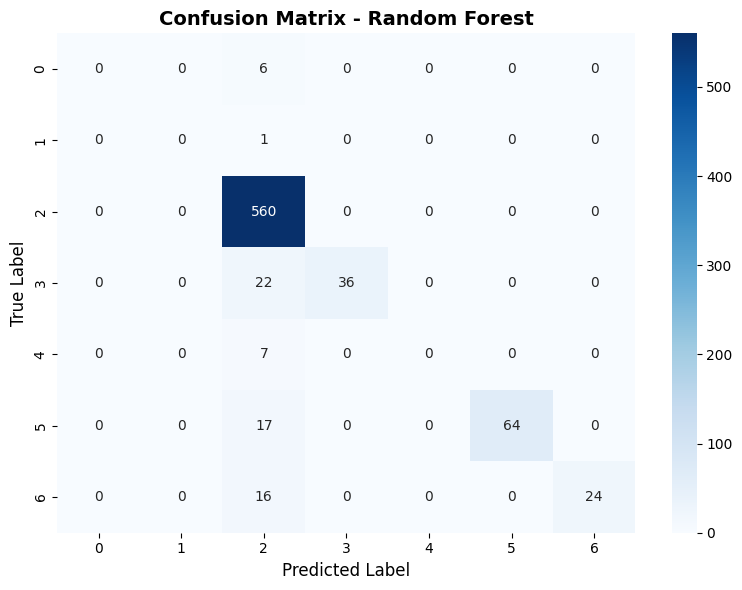

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Train model
rf.fit(X_train_final, y_train)

# Predictions
rf_pred = rf.predict(X_test_final)

# Evaluation
rf_acc = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print("Random Forest Accuracy:", rf_acc)
print("Random Forest F1 Score:", rf_f1)

cm = confusion_matrix(y_test, rf_pred)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Random Forest", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,               # test only 5 random combos
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train_final, y_train)

print("\nBest Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test_final)

rf_acc_best = accuracy_score(y_test, y_pred_best)
rf_f1_best = f1_score(y_test, y_pred_best, average='weighted')

print(f"\n Tuned Random Forest Results:")
print(f"Accuracy: {rf_acc_best:.4f}")
print(f"Weighted F1-Score: {rf_f1_best:.4f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

✅ Tuned Random Forest Results:
Accuracy: 0.9137
Weighted F1-Score: 0.9203


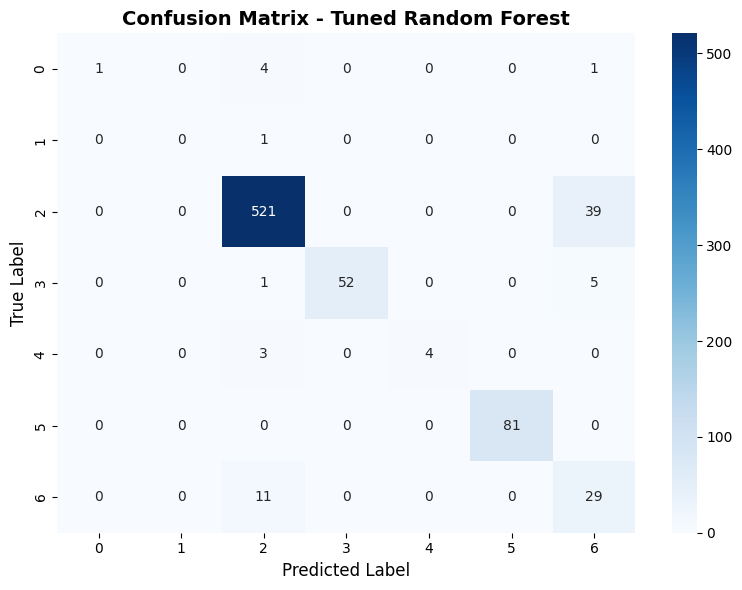

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_test, y_pred_best)
labels = np.unique(y_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - Tuned Random Forest", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()
